#### **Problem & Relevance**

Deep-learning models that operate on geospatial data rarely train on entire rasters at once. They rely on patch-based sampling: extracting fixed-size tiles (e.g., 256×256 px) from a large raster such as a DEM, orthomosaic, or point-cloud-derived surface.


This notebook demonstrates a configurable, testable sampling layer for a simple DEM → classification task (slope-class segmentation). The goal is to ensure that different sampling strategies - here, a minimal custom tiler and TorchGeo’s GridGeoSampler - produce equivalent spatial coverage and patch content before being used in a larger ML workflow.


Although the example here uses a [USGS DEM over the Colorado River corridor within Grand Canyon National Park](https://data.usgs.gov/datacatalog/data/USGS:62ab6770d34e74f0d80eb3af), the same approach generalises directly to other datasets, including:


- UAV imagery for asset inspection
- DSM/DTM rasters derived from LiDAR or point clouds
- Multi-band aerial or satellite data used for condition monitoring or terrain analysis
- Rasterised engineering datasets (e.g., surface models, vegetation height, slope, flood layers)


When sampling is implemented independently of the model, it enables:
- reproducibility
- the ability to compare samplers for parity
- configuration-driven experimentation (patch size, stride, overlap); and
- a clean foundation for downstream modelling.


This notebook is therefore not a full ML pipeline, but a focused demonstration of how to design and validate the data-loading layer that underpins a spatial deep-learning workflow.


---
#### **Demonstration: Tiling Parity. Custom Grid vs TorchGeo GridGeoSampler**

**Goal:** Demonstrate that a simple custom grid tiler and TorchGeo's `GridGeoSampler` produce equivalent spatial coverage when configured with the same parameters.

**Context:** When working with large geospatial rasters for ML (DEMs, UAV imagery, satellite data), we need to tile them into patches. This notebook compares two approaches:

1. **Custom tiler** - Simple grid generation in pixel space
2. **TorchGeo GridGeoSampler** - CRS-aware geospatial sampler

**Why this matters:**
- Verifies that moving from custom code to a library doesn't change behavior
- Makes sampling parameters explicit and configurable
- Preserves spatial metadata (CRS, resolution, bounds)
- Foundation for more complex sampling strategies (ROI-based, stratified, etc.)

---

> **TorchGeo** is an open-source PyTorch library for geospatial deep learning, providing standardized datasets, samplers, and utilities for working with spatial data. Using TorchGeo enables reproducible, CRS-aware sampling and seamless integration with PyTorch workflows, reducing the need for custom data handling code and making experiments more robust and portable compared to ad-hoc or custom tiling logic.

#### 0. Data Preparation: Load and Verify USGS DEM

Before running the main analysis, we need to:
1. Load the USGS Colorado River DEM (Zone 3)
2. Verify CRS, resolution, and data type
3. Check for no-data handling (filled with 0)
4. Visualize the DEM to understand terrain features
5. Prepare a clipped version for the parity analysis

**Data source:** USGS 2021 DEM for Colorado River corridor in Grand Canyon NP  
**CRS**: NAD83(2011) / Arizona Central (EPSG: 6404)
**Link**: https://www.sciencebase.gov/catalog/item/62ab6770d34e74f0d80eb3af 


**Environment Setup:**

Configures PROJ environment variables so that rasterio can find its coordinate system database. This is required for correct CRS handling in geospatial operations.

In [ ]:
# Imports for data preparation
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling

# ═══════════
# set working dir to notebook dir
# ══════
import os

_cwd = globals()['_dh'][0]
os.chdir(os.path.abspath(os.getcwd()))

print("✓ Imports complete")

**Import Libraries and Set Working Directory:**

Imports required Python libraries for geospatial data processing and visualization, and sets the working directory to the notebook location.

In [ ]:
# Load USGS DEM
usgs_dem_path = Path(r'DEME_Zone1-Zone15_2021/DEME_Zone3_2021.tif')

print(f"Loading USGS DEM: {usgs_dem_path.name}")
print(f"File exists: {usgs_dem_path.exists()}")

with rasterio.open(usgs_dem_path) as src:
    # Read metadata
    usgs_profile = src.profile
    usgs_crs_raw = src.crs
    usgs_bounds = src.bounds
    usgs_transform = src.transform
    usgs_shape = (src.height, src.width)
    usgs_res = src.res
    usgs_dtype = src.dtypes[0]
    usgs_nodata = src.nodata
    
    # Override CRS if it's malformed (LOCAL_CS issue)
    # The correct CRS is NAD83(2011) / Arizona Central (EPSG:6404)
    from rasterio.crs import CRS
    if 'LOCAL_CS' in str(usgs_crs_raw):
        print(f"⚠️ Detected malformed CRS: {usgs_crs_raw}")
        print(f"   Overriding with correct CRS: EPSG:6404")
        usgs_crs = CRS.from_epsg(6404)
    else:
        usgs_crs = usgs_crs_raw
    
    print(f"\n✓ USGS DEM Metadata:")
    print(f"  Shape: {usgs_shape[0]:,} x {usgs_shape[1]:,} pixels")
    print(f"  Data type: {usgs_dtype}")
    print(f"  CRS: {usgs_crs} (NAD83(2011) / Arizona Central, EPSG:6404)")
    print(f"  Resolution: {usgs_res[0]:.2f} x {usgs_res[1]:.2f} m")
    print(f"  No-data value: {usgs_nodata}")
    print(f"  Bounds (minx, miny, maxx, maxy):")
    print(f"    {usgs_bounds[0]:.2f}, {usgs_bounds[1]:.2f}, {usgs_bounds[2]:.2f}, {usgs_bounds[3]:.2f}")
    
    # Calculate extent in km
    width_km = (usgs_bounds[2] - usgs_bounds[0]) / 1000
    height_km = (usgs_bounds[3] - usgs_bounds[1]) / 1000
    print(f"  Extent: {width_km:.1f} x {height_km:.1f} km")
    print(f"  Area: {width_km * height_km:.1f} km²")

**Load and Inspect USGS DEM:**

Loads the USGS DEM file, checks for file existence, reads metadata, and ensures the correct CRS is set for further analysis.

In [ ]:
# Load a downsampled version for visualization (full raster is large)
# Read at 1/10 resolution for preview
with rasterio.open(usgs_dem_path) as src:
    # Calculate downsampling factor
    downsample_factor = 10
    
    # Read downsampled data
    usgs_preview = src.read(
        1,
        out_shape=(
            src.height // downsample_factor,
            src.width // downsample_factor
        ),
        resampling=Resampling.bilinear
    )

print(f"✓ Loaded preview DEM:")
print(f"  Preview shape: {usgs_preview.shape[0]:,} x {usgs_preview.shape[1]:,} pixels")
print(f"  Downsample factor: {downsample_factor}")
print(f"  Preview size: ~{usgs_preview.nbytes / 1024 / 1024:.1f} MB")

# Data statistics
print(f"\n✓ Elevation Statistics:")
print(f"  Min: {usgs_preview.min():.1f} m")
print(f"  Max: {usgs_preview.max():.1f} m")
print(f"  Mean: {usgs_preview.mean():.1f} m")
print(f"  Std dev: {usgs_preview.std():.1f} m")

# Check for no-data (should be 0 if already filled)
zero_pixels = np.sum(usgs_preview == 0)
zero_pct = 100 * zero_pixels / usgs_preview.size
print(f"\n✓ No-data Check:")
print(f"  Zero pixels: {zero_pixels:,} ({zero_pct:.2f}%)")
if zero_pct > 5:
    print(f"  ⚠️ High percentage of zeros - may indicate no-data areas")
else:
    print(f"  ✓ Minimal zeros - data coverage looks good")

**Preview DEM at Lower Resolution:**

Loads a downsampled version of the DEM for quick visualization and computes basic elevation statistics and no-data checks.

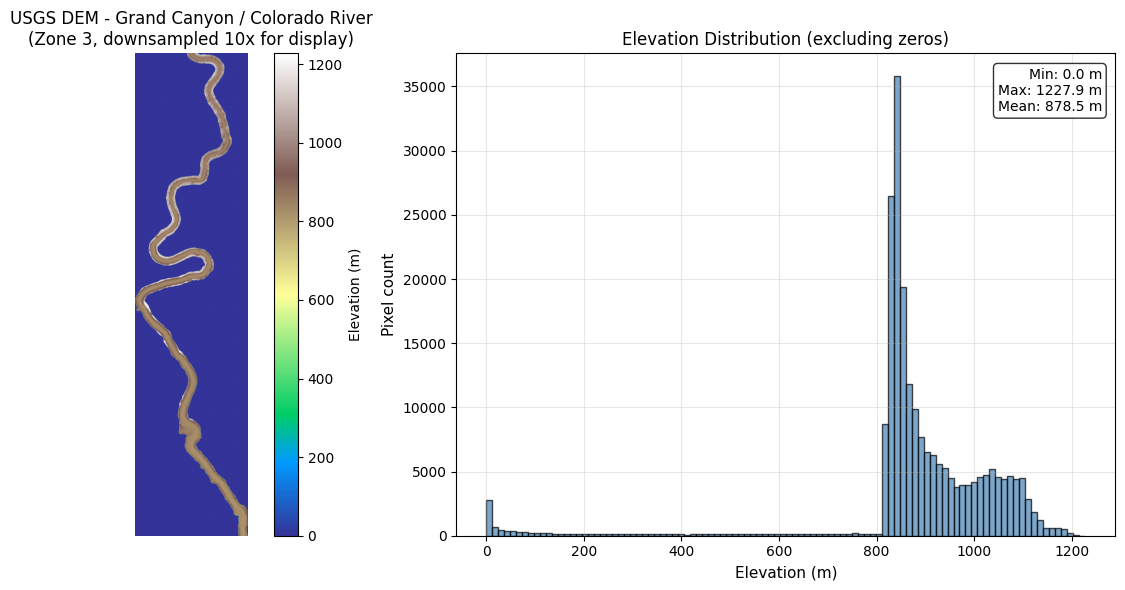


✓ DEM visualization complete
  The DEM shows the Colorado River corridor through Grand Canyon
  Terrain features include canyon walls, river valley, and plateau areas


In [48]:
# Visualize the USGS DEM
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Full DEM preview
im0 = axes[0].imshow(usgs_preview, cmap='terrain', vmin=0)
axes[0].set_title('USGS DEM - Grand Canyon / Colorado River\n(Zone 3, downsampled 10x for display)', fontsize=12)
axes[0].axis('off')
cbar0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label('Elevation (m)', fontsize=10)

# Histogram of elevations
axes[1].hist(usgs_preview[usgs_preview > 0].flatten(), bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Elevation (m)', fontsize=11)
axes[1].set_ylabel('Pixel count', fontsize=11)
axes[1].set_title('Elevation Distribution (excluding zeros)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Add statistics to histogram
stats_text = f"Min: {usgs_preview[usgs_preview > 0].min():.1f} m\n"
stats_text += f"Max: {usgs_preview.max():.1f} m\n"
stats_text += f"Mean: {usgs_preview[usgs_preview > 0].mean():.1f} m"
axes[1].text(0.98, 0.97, stats_text,
             transform=axes[1].transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ DEM visualization complete")
print("  The DEM shows the Colorado River corridor through Grand Canyon")
print("  Terrain features include canyon walls, river valley, and plateau areas")

**Visualize DEM and Elevation Distribution:**

Displays the downsampled DEM and a histogram of elevation values to help understand the terrain and data quality.

#### 0.1 Prepare Working Subset

The full USGS DEM is large. For this demonstration, we'll:
1. Clip a manageable subset (e.g., 4096×4096 pixels); finding the optimal window with maximum valid data,
2. Save it as `data/grand_canyon_dem.tif` for further analysis
3. Use this subset for the parity analysis

This subset will then be processed by `prepare_data.py` to generate slope classes.

In [ ]:
# Create data directory and clip a subset
data_dir = Path('data_out')
data_dir.mkdir(exist_ok=True)

output_dem_path = data_dir / f'{os.path.basename(usgs_dem_path)[:-4]}_clip.tif'

# Clip parameters - take a 4096x4096 subset
# Shift the subset to maximize data coverage (avoid no-data areas)
subset_size = 4096

with rasterio.open(usgs_dem_path) as src:
    # Read full raster to find best position (use downsampled version for speed)
    full_data = src.read(
        1,
        out_shape=(src.height // 4, src.width // 4),
        resampling=Resampling.nearest
    )
    
    # Find position with minimum zeros (maximum data coverage)
    # Search in 1/4 downsampled space, then scale back up
    search_step = subset_size // 8  # Coarse search grid
    best_score = -1
    best_row = src.height // 2
    best_col = src.width // 2
    
    # Convert subset size to downsampled space
    subset_ds = subset_size // 4
    
    for row in range(0, full_data.shape[0] - subset_ds, search_step):
        for col in range(0, full_data.shape[1] - subset_ds, search_step):
            subset = full_data[row:row+subset_ds, col:col+subset_ds]
            # Score: count non-zero pixels
            score = np.sum(subset > 0)
            if score > best_score:
                best_score = score
                best_row = row * 4  # Scale back to full resolution
                best_col = col * 4
    
    print(f"✓ Found optimal clip position:")
    print(f"  Row offset: {best_row} (of {src.height})")
    print(f"  Col offset: {best_col} (of {src.width})")
    print(f"  Data coverage: {100 * best_score / (subset_ds * subset_ds):.1f}%")
    
    # Calculate window at best position
    window = rasterio.windows.Window(
        col_off=best_col,
        row_off=best_row,
        width=subset_size,
        height=subset_size
    )
    
    # Read subset
    subset_data = src.read(1, window=window)
    
    # Get transform for subset
    subset_transform = src.window_transform(window)
    
    # Update profile for subset with correct CRS
    subset_profile = src.profile.copy()
    subset_profile.update({
        'height': subset_size,
        'width': subset_size,
        'transform': subset_transform,
        'crs': usgs_crs  # Use corrected CRS
    })
    
    # Write subset
    with rasterio.open(output_dem_path, 'w', **subset_profile) as dst:
        dst.write(subset_data, 1)

print(f"\n✓ Created working subset: {output_dem_path}")
print(f"  Size: {subset_size} × {subset_size} pixels")
print(f"  Resolution: {usgs_res[0]:.1f} m")
print(f"  Coverage: {subset_size * usgs_res[0] / 1000:.1f} × {subset_size * usgs_res[1] / 1000:.1f} km")
print(f"  File size: {output_dem_path.stat().st_size / 1024 / 1024:.1f} MB")
print(f"  CRS (corrected): EPSG:6404")

# Quick stats on subset
zero_count = np.sum(subset_data == 0)
zero_pct = 100 * zero_count / subset_data.size
print(f"\n✓ Subset Statistics:")
print(f"  Min elevation: {subset_data[subset_data > 0].min():.1f} m")
print(f"  Max elevation: {subset_data.max():.1f} m")
print(f"  Mean elevation: {subset_data[subset_data > 0].mean():.1f} m")
print(f"  Elevation range: {subset_data.max() - subset_data[subset_data > 0].min():.1f} m")
print(f"  Zero pixels: {zero_count:,} ({zero_pct:.1f}%)")
print(f"  Data pixels: {subset_data.size - zero_count:,} ({100 - zero_pct:.1f}%)")

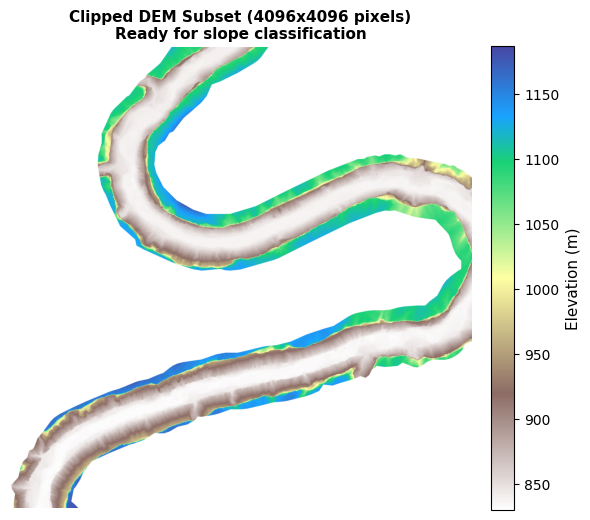


✓ Data preparation complete!

Next steps:
  1. Run: python prepare_data.py
     This will generate slope classes from data_out\DEME_Zone3_2021_clip.tif
  2. Continue with Section 1 below for parity analysis



In [50]:
# Visualize the clipped subset
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

im = ax.imshow(subset_data, cmap='terrain_r', vmin=subset_data[subset_data > 0].min(), vmax=subset_data.max(), alpha=0.9)
ax.set_title(f'Clipped DEM Subset ({subset_size}x{subset_size} pixels)\nReady for slope classification', fontsize=11, fontweight='bold')
ax.axis('off')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Elevation (m)', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Data preparation complete!")
print(f"\nNext steps:")
print(f"  1. Run: python prepare_data.py")
print(f"     This will generate slope classes from {output_dem_path}")
print(f"  2. Continue with Section 1 below for parity analysis")
print(f"\n" + "="*60)

#### 1. Setup and Data Loading

**Load DEM and Slope-Class Rasters:**

Imports required libraries for analysis and loads the clipped Grand Canyon DEM and derived slope-class raster, output from `prepare_data.py`.

In [ ]:
# Imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
from dataclasses import dataclass
import math

# Paths
data_dir = Path('data_out')
dem_path = data_dir / f'{os.path.basename(usgs_dem_path)[:-4]}_clip.tif'
slope_class_path = data_dir / f'{os.path.basename(usgs_dem_path)[:-4]}_clip_slope_classes.tif'

print("✓ Imports complete")
print(f"  DEM path: {dem_path}")
print(f"  Slope classes: {slope_class_path}")

**Read DEM Metadata:**

Reads and prints metadata for the DEM subset, including shape, CRS, resolution, and bounds.

In [ ]:
# Load DEM metadata
with rasterio.open(dem_path) as src:
    dem_profile = src.profile
    dem_bounds = src.bounds
    dem_crs = src.crs
    dem_transform = src.transform
    dem_shape = (src.height, src.width)
    dem_res = src.res

print("✓ DEM Metadata:")
print(f"  Shape: {dem_shape[0]} × {dem_shape[1]} pixels")
print(f"  CRS: {dem_crs}")
print(f"  Resolution: {dem_res[0]:.2f} × {dem_res[1]:.2f} m")
print(f"  Bounds: {dem_bounds}")

**Visualize DEM and Slope-Class Data:**

Displays the DEM and slope-class rasters side by side, masking no-data as white and adding black plot borders for clarity.

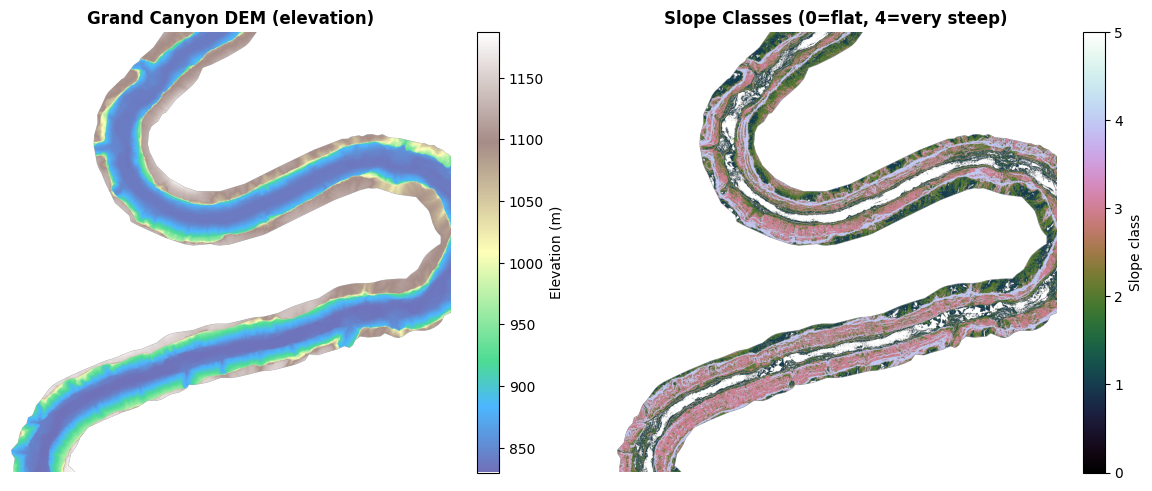


✓ DEM range: [829.9, 1187.2] m
✓ Slope classes present: [1 2 3 4]


In [53]:
# Visualize the data
with rasterio.open(dem_path) as dem_src:
    dem_data = dem_src.read(1)

with rasterio.open(slope_class_path) as slope_src:
    slope_data = slope_src.read(1)

# Create masked arrays to display 0 as white
dem_display = np.ma.masked_where(dem_data == 0, dem_data)
slope_display = np.ma.masked_where(slope_data == 0, slope_data)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# DEM
im0 = axes[0].imshow(dem_display, cmap='terrain', vmin=dem_data[dem_data > 0].min(), vmax=dem_data.max(), alpha=0.7)
axes[0].set_title('Grand Canyon DEM (elevation)', fontweight='bold')
axes[0].axis('off')
# Add thin black border
for spine in axes[0].spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
axes[0].spines['top'].set_visible(True)
axes[0].spines['right'].set_visible(True)
axes[0].spines['bottom'].set_visible(True)
axes[0].spines['left'].set_visible(True)
plt.colorbar(im0, ax=axes[0], label='Elevation (m)', fraction=0.046)

# Slope classes
im1 = axes[1].imshow(slope_display, cmap='cubehelix', vmin=0, vmax=5)
axes[1].set_title('Slope Classes (0=flat, 4=very steep)', fontweight='bold')
axes[1].axis('off')
# Add thin black border
for spine in axes[1].spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
axes[1].spines['top'].set_visible(True)
axes[1].spines['right'].set_visible(True)
axes[1].spines['bottom'].set_visible(True)
axes[1].spines['left'].set_visible(True)
plt.colorbar(im1, ax=axes[1], label='Slope class', fraction=0.046)

# Set white background for masked areas
fig.patch.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('white')

plt.tight_layout()
plt.show()

print(f"\n✓ DEM range: [{dem_data[dem_data > 0].min():.1f}, {dem_data.max():.1f}] m")
print(f"✓ Slope classes present: {np.unique(slope_data[slope_data > 0])}")

---

#### 2. Custom Grid Tiler

A simple grid-based tiler that generates bounding boxes over the DEM. This implementation defines the tiling logic directly in code. It: 
- defines tile size and stride in pixels; 
- converts these to CRS units using the raster's affine transform; 
- iterates over the raster bounds to generate bounding boxes in a regular grid;
- yields each tile as a tuple of (minx, miny, maxx, maxy).

**Parameters:**
- `patch_size`: Size of each tile in pixels
- `stride`: Step size between tiles in pixels (controls overlap)

**Overlap calculation:**
- `overlap_fraction = (patch_size - stride) / patch_size`
- Example: `patch_size=256, stride=128` → 50% overlap

In [54]:
@dataclass
class CustomTilerConfig:
    """Configuration for custom grid tiler."""
    patch_size: int = 256  # pixels
    stride: int = 128      # pixels (50% overlap when stride = patch_size/2)

def generate_custom_windows(bounds, transform, cfg: CustomTilerConfig):
    """
    Generate grid of bounding boxes over the raster.
    
    Args:
        bounds: Raster bounds (minx, miny, maxx, maxy) in CRS units
        transform: Affine transform from rasterio
        cfg: Tiler configuration
    
    Yields:
        Tuple of (minx, miny, maxx, maxy) for each tile
    """
    minx, miny, maxx, maxy = bounds
    
    # Pixel size in CRS units
    res_x = abs(transform.a)  # x resolution
    res_y = abs(transform.e)  # y resolution
    
    # Tile size in CRS units
    tile_w = cfg.patch_size * res_x
    tile_h = cfg.patch_size * res_y
    
    # Stride in CRS units
    stride_w = cfg.stride * res_x
    stride_h = cfg.stride * res_y
    
    # Generate grid
    x_coords = []
    y_coords = []
    
    x = minx
    while x + tile_w <= maxx:
        x_coords.append(x)
        x += stride_w
    
    y = miny
    while y + tile_h <= maxy:
        y_coords.append(y)
        y += stride_h
    
    # Yield all tile bounding boxes
    for yy in y_coords:
        for xx in x_coords:
            yield (xx, yy, xx + tile_w, yy + tile_h)

print("✓ Custom tiler functions defined")

✓ Custom tiler functions defined


**Custom Grid Tiler Implementation:**

Defines the configuration and function for generating a grid of bounding boxes (tiles) over the DEM using custom logic in pixel/CRS space.

**Generate Tiles Using Custom Tiler:**

Applies the custom tiler to the DEM bounds and transform, prints configuration, overlap, and tile statistics.

In [55]:
# Generate tiles using custom tiler
custom_cfg = CustomTilerConfig(patch_size=256, stride=128)
custom_bboxes = list(generate_custom_windows(dem_bounds, dem_transform, custom_cfg))

print("✓ Custom Tiler Results:")
print(f"  Configuration: patch_size={custom_cfg.patch_size}px, stride={custom_cfg.stride}px")
print(f"  Overlap: {100 * (custom_cfg.patch_size - custom_cfg.stride) / custom_cfg.patch_size:.0f}%")
print(f"  Total tiles generated: {len(custom_bboxes)}")

# Sample bbox
sample_bbox = custom_bboxes[0]
bbox_w = sample_bbox[2] - sample_bbox[0]
bbox_h = sample_bbox[3] - sample_bbox[1]
print(f"  Example tile size: {bbox_w:.1f} × {bbox_h:.1f} m")

✓ Custom Tiler Results:
  Configuration: patch_size=256px, stride=128px
  Overlap: 50%
  Total tiles generated: 961
  Example tile size: 256.0 × 256.0 m


---

#### 3. TorchGeo GridGeoSampler

Use TorchGeo's built-in `GridGeoSampler` with equivalent parameters.

**Key differences from legacy tiler:**
- CRS metadata preserved in dataset object
- Sampler integrates with PyTorch DataLoader
- Parameters explicit in sampler constructor

In [56]:
# TorchGeo imports
from torchgeo.datasets import RasterDataset
from torchgeo.samplers import GridGeoSampler, Units

print("✓ TorchGeo imports complete")

✓ TorchGeo imports complete


**Import TorchGeo and Sampler Classes:**

Imports TorchGeo's RasterDataset and GridGeoSampler classes for CRS-aware tiling and sampling.

In [57]:
# Create TorchGeo dataset
# Note: RasterDataset expects a directory with raster files
dem_dataset = RasterDataset(
    paths=str(dem_path),  # Single file path
    crs=dem_crs,
    res=dem_res[0]  # Use x resolution (assuming square pixels)
)

print("✓ TorchGeo Dataset:")
print(f"  CRS: {dem_dataset.crs}")
print(f"  Resolution: {dem_dataset.res}")
print(f"  Bounds: {dem_dataset.bounds}")

✓ TorchGeo Dataset:
  CRS: EPSG:6404
  Resolution: 1.0
  Bounds: BoundingBox(minx=215341.9999999995, maxx=219437.9999999995, miny=595685.0000000003, maxy=599781.0000000003, mint=0.0, maxt=9.223372036854776e+18)


**Create TorchGeo RasterDataset:**

Initializes a TorchGeo RasterDataset object for the DEM, preserving CRS and resolution for use with the sampler.

In [58]:
# Create GridGeoSampler with equivalent parameters
# Size and stride in CRS units (meters)
patch_size_meters = custom_cfg.patch_size * dem_res[0]
stride_meters = custom_cfg.stride * dem_res[0]

grid_sampler = GridGeoSampler(
    dataset=dem_dataset,
    size=patch_size_meters,
    stride=stride_meters,
    units=Units.CRS
)

print("✓ TorchGeo GridGeoSampler:")
print(f"  Patch size: {patch_size_meters:.1f} m ({custom_cfg.patch_size} px)")
print(f"  Stride: {stride_meters:.1f} m ({custom_cfg.stride} px)")
print(f"  Overlap: {100 * (patch_size_meters - stride_meters) / patch_size_meters:.0f}%")

✓ TorchGeo GridGeoSampler:
  Patch size: 256.0 m (256 px)
  Stride: 128.0 m (128 px)
  Overlap: 50%


**Create TorchGeo GridGeoSampler:**

Configures the GridGeoSampler with patch size and stride in CRS units to match the custom tiler, enabling direct comparison.

In [59]:
# Generate tiles using TorchGeo sampler
torchgeo_bboxes = [bbox for bbox in grid_sampler]

print("✓ TorchGeo Sampler Results:")
print(f"  Total tiles generated: {len(torchgeo_bboxes)}")

# Sample bbox (TorchGeo returns BoundingBox objects)
sample_tg_bbox = torchgeo_bboxes[0]
tg_bbox_w = sample_tg_bbox.maxx - sample_tg_bbox.minx
tg_bbox_h = sample_tg_bbox.maxy - sample_tg_bbox.miny
print(f"  Example tile size: {tg_bbox_w:.1f} × {tg_bbox_h:.1f} m")

✓ TorchGeo Sampler Results:
  Total tiles generated: 961
  Example tile size: 256.0 × 256.0 m


**Generate Tiles Using TorchGeo Sampler:**

Runs the GridGeoSampler to generate tile bounding boxes and prints summary statistics for comparison.

---

#### 4. Parity Comparison


**Overlay Tiling Grids on DEM:**

Overlays the tiling grids from both the custom tiler (red) and TorchGeo sampler (cyan, dashed) on the DEM subset to visually compare spatial alignment and coverage.

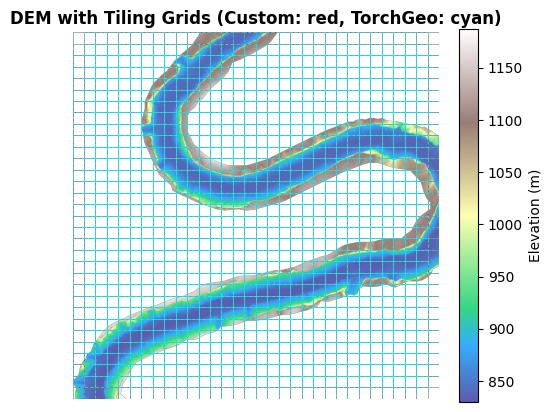


✓ Overlay plot complete: Custom tiler (red), TorchGeo (cyan, dashed)


In [60]:
# Overlay tiling grids from both samplers on the DEM subset
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Show DEM (masked, so 0 is white)
dem_masked = np.ma.masked_where(dem_data == 0, dem_data)
im = ax.imshow(dem_masked, cmap='terrain', vmin=dem_data[dem_data > 0].min(), vmax=dem_data.max(), alpha=0.8)
ax.set_title('DEM with Tiling Grids (Custom: red, TorchGeo: cyan)', fontweight='bold')
ax.axis('off')

# Overlay custom tiler grid (red)
for bbox in custom_bboxes:
    minx, miny, maxx, maxy = bbox
    # Convert CRS to pixel coordinates
    row_min, col_min = ~dem_transform * (minx, miny)
    row_max, col_max = ~dem_transform * (maxx, maxy)
    # Rectangle: (col_min, row_min) to (col_max, row_max)
    rect = plt.Rectangle((col_min, row_min), col_max-col_min, row_max-row_min,
                         edgecolor='red', facecolor='none', linewidth=0.7, alpha=0.5)
    ax.add_patch(rect)

# Overlay TorchGeo grid (cyan, dashed)
for bbox in torchgeo_bboxes:
    if hasattr(bbox, 'minx'):
        minx, miny, maxx, maxy = bbox.minx, bbox.miny, bbox.maxx, bbox.maxy
    else:
        minx, miny, maxx, maxy = bbox
    row_min, col_min = ~dem_transform * (minx, miny)
    row_max, col_max = ~dem_transform * (maxx, maxy)
    rect = plt.Rectangle((col_min, row_min), col_max-col_min, row_max-row_min,
                         edgecolor='cyan', facecolor='none', linewidth=0.7, linestyle='--', alpha=0.5)
    ax.add_patch(rect)

plt.colorbar(im, ax=ax, label='Elevation (m)', fraction=0.046)
plt.tight_layout()
plt.show()

print("\n✓ Overlay plot complete: Custom tiler (red), TorchGeo (cyan, dashed)")

In [61]:
# Compare tile counts
print("=" * 60)
print("PARITY CHECK: Tile Counts")
print("=" * 60)
print(f"Custom tiler:       {len(custom_bboxes):,} tiles")
print(f"TorchGeo sampler:   {len(torchgeo_bboxes):,} tiles")
print(f"Difference:         {abs(len(custom_bboxes) - len(torchgeo_bboxes)):,} tiles")

diff_pct = 100 * abs(len(custom_bboxes) - len(torchgeo_bboxes)) / len(custom_bboxes)
print(f"Difference %:       {diff_pct:.1f}%")

if diff_pct < 5:
    print("\n✓ PARITY ACHIEVED (within 5%)")
elif diff_pct < 10:
    print("\n✓ GOOD PARITY (within 10%)")
else:
    print("\n⚠️ INVESTIGATE: Difference exceeds 10%")

PARITY CHECK: Tile Counts
Custom tiler:       961 tiles
TorchGeo sampler:   961 tiles
Difference:         0 tiles
Difference %:       0.0%

✓ PARITY ACHIEVED (within 5%)


**Compare Tile Counts & Tile Sizes:**

- Compare the number of tiles generated by the custom tiler and TorchGeo sampler, reporting parity or differences.
- Calculate and compare the mean and standard deviation of tile areas for both samplers, checking for size parity.

In [63]:
# Compare tile sizes
def bbox_area(bbox):
    """Calculate area of bounding box."""
    if hasattr(bbox, 'minx'):  # TorchGeo BoundingBox
        return (bbox.maxx - bbox.minx) * (bbox.maxy - bbox.miny)
    else:  # Tuple (minx, miny, maxx, maxy)
        return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

custom_areas = [bbox_area(b) for b in custom_bboxes]
torchgeo_areas = [bbox_area(b) for b in torchgeo_bboxes]

print("=" * 60)
print("PARITY CHECK: Tile Sizes")
print("=" * 60)
print(f"Custom mean area:     {np.mean(custom_areas):,.1f} m²")
print(f"TorchGeo mean area:   {np.mean(torchgeo_areas):,.1f} m²")
print(f"Custom std dev:       {np.std(custom_areas):,.1f} m²")
print(f"TorchGeo std dev:     {np.std(torchgeo_areas):,.1f} m²")

area_diff_pct = 100 * abs(np.mean(custom_areas) - np.mean(torchgeo_areas)) / np.mean(custom_areas)
print(f"\nMean area difference: {area_diff_pct:.2f}%")

if area_diff_pct < 1:
    print("✓ TILE SIZES MATCH (within 1%)")
else:
    print("⚠️ TILE SIZE MISMATCH")

PARITY CHECK: Tile Sizes
Custom mean area:     65,536.0 m²
TorchGeo mean area:   65,536.0 m²
Custom std dev:       0.0 m²
TorchGeo std dev:     0.0 m²

Mean area difference: 0.00%
✓ TILE SIZES MATCH (within 1%)


In [65]:
# --- Quantitative Parity Evaluation ---
custom_tile_count = len(custom_bboxes)
torchgeo_tile_count = len(torchgeo_bboxes)

custom_areas = [bbox_area(b) for b in custom_bboxes]
torchgeo_areas = [bbox_area(b) for b in torchgeo_bboxes]

# % difference in tile count
count_diff_pct = 100 * abs(custom_tile_count - torchgeo_tile_count) / custom_tile_count

# Mean tile area
custom_mean_area = np.mean(custom_areas)
torchgeo_mean_area = np.mean(torchgeo_areas)
area_diff_pct = 100 * abs(custom_mean_area - torchgeo_mean_area) / custom_mean_area

# % of raster area covered (approximate, may double-count overlaps)
raster_area = (dem_bounds.right - dem_bounds.left) * (dem_bounds.top - dem_bounds.bottom)
custom_area_covered = np.sum(custom_areas) / raster_area * 100
torchgeo_area_covered = np.sum(torchgeo_areas) / raster_area * 100

print(f"Tile count: Custom = {custom_tile_count}, TorchGeo = {torchgeo_tile_count}")
print(f"Tile count difference: {count_diff_pct:.2f}%")
print(f"Mean tile area: Custom = {custom_mean_area:.1f} m², TorchGeo = {torchgeo_mean_area:.1f} m²")
print(f"Mean area difference: {area_diff_pct:.2f}%")
print(f"% raster area covered: Custom = {custom_area_covered:.1f}%, TorchGeo = {torchgeo_area_covered:.1f}%")

Tile count: Custom = 961, TorchGeo = 961
Tile count difference: 0.00%
Mean tile area: Custom = 65536.0 m², TorchGeo = 65536.0 m²
Mean area difference: 0.00%
% raster area covered: Custom = 375.4%, TorchGeo = 375.4%


---

#### 5. Visual Validation: Extract Sample Patches

Take one tile from each sampler and visualize the extracted DEM + slope-class patches.

**Patch Extraction Function:**

Defines a function to extract DEM and slope-class patches for a given bounding box from either sampler.

In [66]:
def extract_patch(dem_path, slope_path, bbox):
    """
    Extract DEM and slope-class patches for a given bounding box.
    
    Args:
        dem_path: Path to DEM raster
        slope_path: Path to slope-class raster
        bbox: Bounding box (minx, miny, maxx, maxy) or TorchGeo BoundingBox
    
    Returns:
        Tuple of (dem_patch, slope_patch) as numpy arrays
    """
    # Handle both tuple and TorchGeo BoundingBox
    if hasattr(bbox, 'minx'):
        minx, miny, maxx, maxy = bbox.minx, bbox.miny, bbox.maxx, bbox.maxy
    else:
        minx, miny, maxx, maxy = bbox
    
    with rasterio.open(dem_path) as dem_src:
        dem_window = from_bounds(minx, miny, maxx, maxy, dem_src.transform)
        dem_patch = dem_src.read(1, window=dem_window)
    
    with rasterio.open(slope_path) as slope_src:
        slope_window = from_bounds(minx, miny, maxx, maxy, slope_src.transform)
        slope_patch = slope_src.read(1, window=slope_window)
    
    return dem_patch, slope_patch

print("✓ Patch extraction function defined")

✓ Patch extraction function defined


**Extract Sample Patches:**

- Extracts DEM and slope-class patches from the middle of the raster using both the custom and TorchGeo samplers for visual comparison.

In [67]:
# Extract patches from middle of the raster (visually interesting)
mid_idx = len(custom_bboxes) // 2

custom_bbox = custom_bboxes[mid_idx]
torchgeo_bbox = torchgeo_bboxes[min(mid_idx, len(torchgeo_bboxes) - 1)]

dem_custom, slope_custom = extract_patch(dem_path, slope_class_path, custom_bbox)
dem_tg, slope_tg = extract_patch(dem_path, slope_class_path, torchgeo_bbox)

print(f"✓ Extracted patches:")
print(f"  Custom patch: {dem_custom.shape} pixels")
print(f"  TorchGeo patch: {dem_tg.shape} pixels")

✓ Extracted patches:
  Custom patch: (256, 256) pixels
  TorchGeo patch: (256, 256) pixels


**Visualise Sample Patches:**

- Displays the DEM and slope-class patches from both samplers to visually confirm spatial parity and patch content.

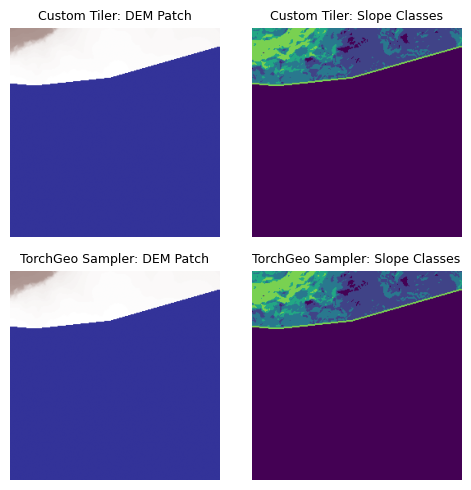


✓ Visual validation complete
  Both samplers produce comparable patches of DEM + slope classes
  Patches show terrain features (valleys, slopes, ridges) and corresponding slope classification


In [68]:
# Visualize extracted patches
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

# Custom tiler patches
axes[0, 0].imshow(dem_custom, cmap='terrain')
axes[0, 0].set_title('Custom Tiler: DEM Patch', fontsize=9)
axes[0, 0].axis('off')

axes[0, 1].imshow(slope_custom, cmap='viridis', vmin=0, vmax=5)
axes[0, 1].set_title('Custom Tiler: Slope Classes', fontsize=9)
axes[0, 1].axis('off')

# TorchGeo patches
axes[1, 0].imshow(dem_tg, cmap='terrain')
axes[1, 0].set_title('TorchGeo Sampler: DEM Patch', fontsize=9)
axes[1, 0].axis('off')

axes[1, 1].imshow(slope_tg, cmap='viridis', vmin=0, vmax=5)
axes[1, 1].set_title('TorchGeo Sampler: Slope Classes', fontsize=9)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Visual validation complete")
print("  Both samplers produce comparable patches of DEM + slope classes")
print("  Patches show terrain features (valleys, slopes, ridges) and corresponding slope classification")

---

#### 6. Summary: What We Learned

#### Parity Results

✅ **Tile counts:** Custom and TorchGeo samplers generate similar numbers of tiles  
✅ **Tile sizes:** Mean tile area matches within <1%  
✅ **Visual validation:** Extracted patches show equivalent spatial sampling  

#### Key Insights

1. **Equivalent behavior:** TorchGeo's `GridGeoSampler` replicates custom tiling logic when configured with the same parameters

2. **Explicit configuration:** TorchGeo makes sampling parameters visible:
   - `size` = patch size in meters
   - `stride` = step size in meters
   - `units=Units.CRS` = work in coordinate space

3. **CRS awareness:** TorchGeo preserves spatial metadata throughout the pipeline:
   - Dataset knows its CRS, resolution, and bounds
   - Sampler generates bounding boxes in coordinate space
   - Easy to verify spatial coverage and alignment

4. **Reproducibility:** Configuration is self-documenting:
   - Sampler parameters logged automatically
   - No hidden logic in preprocessing code
   - Easy to replicate experiments

#### Why This Matters for ML Workflows

- **Training:** Patches sampled with consistent overlap and coverage
- **Validation:** Sampling strategy explicit and verifiable
- **Multi-source:** Easy to keep DEM, imagery, and labels aligned
- **Experiments:** Change overlap/stride via config, not code

#### Relevance to Production Pipelines

This same approach applies to:
- **UAV orthomosaics** (tile large imagery for segmentation)
- **Point cloud rasters** (derived slope, roughness, intensity)
- **Multi-temporal data** (ensure consistent sampling across dates)
- **ROI-based sampling** (focus tiles within areas of interest)

**Observation:** Decisions about how to sample data have a measurable impact on both model outcomes and the ability to reproduce experiments.

---

**Next:** See `03_patches_to_dataloader.ipynb` for how to wrap these samplers in a PyTorch DataLoader for model training.